## Benchmarking on Lomonosov-2
- some benchmarking needed first
 
we will run a series of 100 ps simulation on different number of nodes and make a plot.

In [81]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
from IPython.display import Markdown, display
from config import folder,descr,pname,ssh_host
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("SSH host set to:",ssh_host)




# MD simulations of H3-H4 with 30 bp of DNA, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm_DNA
Project name:  h3-h4_tm_DNA
SSH host set to: lomo2g


## Bench runs 100 ps - prepare files

In [82]:
%%bash  
#--out out --err err
gmx grompp -f MDProtocols/bench.mdp -c GMX_run/6_equil.gro -p GMX_system/topol.top \
-o GMX_run/bench.tpr -v  -r GMX_run/6_equil.gro -n GMX_system/index.ndx -po GMX_run/mdout_bench.mdp


processing topology...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.836 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 0.801 nm, buffer size 0.001 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 112x112x112, spacing 0.116 0.116 0.116
This run will generate roughly 14 Mb of data


                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

## We'll duplicate bench.tpr for simulations with different number of nodes.

In [83]:
%%bash
for i in `seq 1 20`; do
cp GMX_run/bench.tpr GMX_run/bench$i.tpr 
done

### Transfer to Lomonosov2

In [85]:
!cp Run_scripts/lomo2_run.sh GMX_run/
!ssh $ssh_host "mkdir -p ~/_scratch/$folder"
!ssh $ssh_host "mkdir -p ~/_scratch/$folder/GMX_run"
!scp GMX_run/lomo2_run.sh $ssh_host:~/_scratch/$folder/GMX_run/;
!scp GMX_run/bench*.tpr $ssh_host:~/_scratch/$folder/GMX_run/;    

   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!


lomo2_run.sh                                  100% 1042   191.7KB/s   00:00    
   Lomonosov-2 supercomputer welcomes you!


bench.tpr                                     100% 5153KB  45.7MB/s   00:00    
bench1.tpr                                    100% 5153KB  52.3MB/s   00:00    
bench10.tpr                                   100% 5153KB  60.6MB/s   00:00    
bench11.tpr                                   100% 5153KB  61.8MB/s   00:00    
bench12.tpr                                   100% 5153KB  64.2MB/s   00:00    
bench13.tpr                                   100% 5153KB  57.5MB/s   00:00    
bench14.tpr                                   100% 5153KB  56.2MB/s   00:00    
bench15.tpr                                   100% 5153KB  64.8MB/s   00:00    
bench16.tpr                                   100% 5153KB  66.8MB/s   00:00    
bench17.tpr         

### Now let's Launch
Note: there are limits on number of jobs that can be submitted (currently 8), so you'll need to submit in smaller batches.

In [86]:
%%bash -s "$folder" "$ssh_host"
#--err err
#--out out 
for i in `seq 1 6`; do
ssh $2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p compute -t 1:00:00 -N $i -J $1 lomo2_run.sh bench$i"
done

Submitted batch job 939953
Submitted batch job 939954
Submitted batch job 939955
Submitted batch job 939956
Submitted batch job 939957
Submitted batch job 939958


   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!




In [129]:
!ssh $ssh_host "module load slurm gromacs/2018-gcc; squeue -u \`whoami\` " || echo "No job in queue"

   Lomonosov-2 supercomputer welcomes you!


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            927312   compute h3-h4_tm gorkovet  R 1-12:46:47      4 n[51624-51627]
            936092   compute h3-h4_2_ gorkovet  R   22:46:37      8 n[49523-49530]
            939990   compute h3-h4_tm gorkovet  R      13:57      4 n[53317-53320]


In [132]:
%%bash -s "$folder" "$ssh_host"  --err err
for i in `seq 13 17`; do
ssh $2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p compute -t 1:00:00 -N $i -J $1 lomo2_run.sh bench$i"
done

Submitted batch job 940106
Submitted batch job 940107
Submitted batch job 940109
Submitted batch job 940110
Submitted batch job 940111


### Let's get back data

In [130]:
%%bash -s "$folder" "$ssh_host" --err err --out out
#Get back data from log-files

scp $2:~/_scratch/$1/GMX_run/*.log GMX_run/ ;

#### Analyze what we get

In [131]:
speed=[]
nodes=list(range(1,21))
for k in nodes:
    try:
        with open('GMX_run/bench%d.log'%k) as f:
            data=f.read()
            ns_per_day=re.findall(r'Performance:\s+(\d+)\.', data)[0]
            print(k, ns_per_day)
            speed.append([k,float(ns_per_day)])
    except:
        pass

1 9
2 40
3 52
4 62
5 64
6 68
8 82
9 83
10 87
12 98


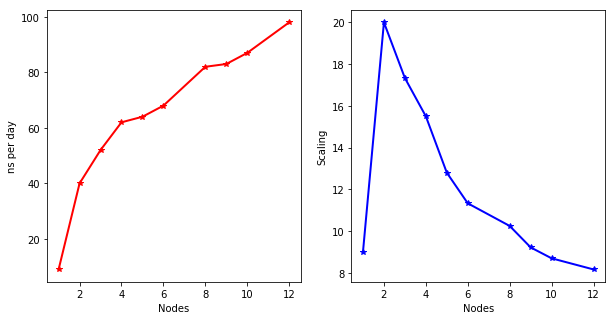

In [133]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
ax = plt.subplot(121)
speed=np.array(speed)
ax.plot(speed[:,0], speed[:,1], 'r*-', lw=2, label=r"ns per day")
ax.set_xlabel("Nodes")
ax.set_ylabel("ns per day")
ax2 = plt.subplot(122)
ax2.plot(speed[:,0], np.divide(speed[:,1],speed[:,0]), 'b*-', lw=2, label=r"ns per day")
ax2.set_xlabel("Nodes")
ax2.set_ylabel("Scaling")
plt.draw()